# December 2017: Advent of Code Solutions

Peter Norvig

I'm doing the [Advent of Code](https://adventofcode.com) puzzles, just like [last year](https://github.com/norvig/pytudes/blob/master/ipynb/Advent%20of%20Code.ipynb). My terms of engagement are:

* You'll need to follow the links in the section headers (e.g. **[Day 1](https://adventofcode.com/2017/day/1)**) to understand what each puzzle is asking; I won't repeat the puzzle description.
* What you see is mostly the algorithm I came up with first, although sometimes I go back and refactor for clarity.
* I'll clean up the code a bit: adding docstrings, making variable names longer and more descriptive, adding `assert` statements.
* I will discuss any errors I made along the way; usually I won't show the erroneous code, just a description of what I did wrong.
* The way Advent of Code works is that you read the puzzle descriotion for Part One, but only when you correctly solve it do you get to see Part Two. This is typical in software development: you deploy some code, and then some new requirements arise. So it makes sense to program by creating small functions and data types that form a *vocabulary* for the domain at hand, and can be recombined to solve new problems in the domain.
* Each day's code should run in a few seconds; certainly less than a minute.
* There is a contest to see who can solve each day's puzzle fastest; I do not expect to be competitive.





# Day 0: Imports and Utility Functions

I might need these:

In [1]:
# Python 3.x Utility Functions

%matplotlib inline
import matplotlib.pyplot as plt

import re
import numpy as np
import math
import random
import time

from collections import Counter, defaultdict, namedtuple, deque, abc, OrderedDict
from functools   import lru_cache
from statistics  import mean, median, mode, stdev, variance
from itertools   import (permutations, combinations, chain, cycle, product, islice, 
                         takewhile, zip_longest, count as count_from)
from heapq       import heappop, heappush
from numba       import jit

letters  = 'abcdefghijklmnopqrstuvwxyz'

cache = lru_cache(None)

cat = ''.join

Ø   = frozenset() # Empty set
inf = float('inf')
BIG = 10 ** 999

################ Functions for Input, Parsing

def Input(day, year=2017):
    "Open this day's input file."
    return open('data/advent{}/input{}.txt'.format(year, day))

def Inputstr(day, year=2017): 
    "The contents of this day's input file as a str."
    return Input(day, year).read().rstrip('\n')
    
def Array(lines):
    "Parse an iterable of str lines into a 2-D array. If `lines` is a str, splitlines."
    if isinstance(lines, str): lines = lines.splitlines()
    return mapt(Vector, lines)

def Vector(line):
    "Parse a str into a tuple of atoms (numbers or str tokens)."
    return mapt(Atom, line.replace(',', ' ').split())

def Integers(text): 
    "Return a tuple of all integers in a string."
    return mapt(int, re.findall(r'-?\b\d+\b', text))

def Atom(token):
    "Parse a str token into a number, or leave it as a str."
    try:
        return int(token)
    except ValueError:
        try:
            return float(token)
        except ValueError:
            return token
        
def error(err=RuntimeError, *args): raise err(*args)

################ Functions on Iterables

def first(iterable, default=None): 
    "The first item in an iterable, or default if it is empty."
    return next(iter(iterable), default)

def first_true(iterable, pred=None, default=None):
    """Returns the first true value in the iterable.
    If no true value is found, returns *default*
    If *pred* is not None, returns the first item
    for which pred(item) is true."""
    # first_true([a,b,c], default=x) --> a or b or c or x
    # first_true([a,b], fn, x) --> a if fn(a) else b if fn(b) else x
    return next(filter(pred, iterable), default)

def nth(iterable, n, default=None):
    "Returns the nth item of iterable, or a default value"
    return next(islice(iterable, n, None), default)

def upto(iterable, maxval):
    "From a monotonically increasing iterable, generate all the values <= maxval."
    # Why <= maxval rather than < maxval? In part because that's how Ruby's upto does it.
    return takewhile(lambda x: x <= maxval, iterable)

identity = lambda x: x

def groupby(iterable, key=identity):
    "Return a dict of {key(item): [items...]} grouping all items in iterable by keys."
    groups = defaultdict(list)
    for item in iterable:
        groups[key(item)].append(item)
    return groups

def grouper(iterable, n, fillvalue=None):
    """Collect data into fixed-length chunks:
    grouper('ABCDEFG', 3, 'x') --> ABC DEF Gxx"""
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

def overlapping(iterable, n):
    """Generate all (overlapping) n-element subsequences of iterable.
    overlapping('ABCDEFG', 3) --> ABC BCD CDE DEF EFG"""
    if isinstance(iterable, abc.Sequence):
        yield from (iterable[i:i+n] for i in range(len(iterable) + 1 - n))
    else:
        result = deque(maxlen=n)
        for x in iterable:
            result.append(x)
            if len(result) == n:
                yield tuple(result)
                
def pairwise(iterable):
    "s -> (s0,s1), (s1,s2), (s2, s3), ..."
    return overlapping(iterable, 2)

def sequence(iterable, type=tuple):
    "Coerce iterable to sequence: leave alone if already a sequence, else make it `type`."
    return iterable if isinstance(iterable, abc.Sequence) else type(iterable)

def join(iterable, sep=''):
    "Join the items in iterable, converting each to a string first."
    return sep.join(map(str, iterable))
                
def powerset(iterable):
    "Yield all subsets of items."
    items = list(iterable)
    for r in range(len(items)+1):
        for c in combinations(items, r):
            yield c
            
def quantify(iterable, pred=bool):
    "Count how many times the predicate is true."
    return sum(map(pred, iterable))

def length(iterable):
    "Same as len(list(iterable)), but without consuming memory."
    return sum(1 for _ in iterable)

def shuffled(iterable):
    "Create a new list out of iterable, and shuffle it."
    new = list(iterable)
    random.shuffle(new)
    return new
    
flatten = chain.from_iterable

################ Functional programming

def mapt(fn, *args): 
    "Do a map, and make the results into a tuple."
    return tuple(map(fn, *args))

def map2d(fn, grid):
    "Apply fn to every element in a 2-dimensional grid."
    return tuple(mapt(fn, row) for row in grid)

def repeat(n, fn, arg, *args, **kwds):
    "Repeat arg = fn(arg) n times, return arg."
    return nth(repeatedly(fn, arg, *args, **kwds), n)

def repeatedly(fn, arg, *args, **kwds):
    "Yield arg, fn(arg), fn(fn(arg)), ..."
    yield arg
    while True:
        arg = fn(arg, *args, **kwds)
        yield arg
        
def compose(f, g): 
    "The function that computes f(g(x))."
    return lambda x: f(g(x))

################ Making immutable objects
            
class Set(frozenset):
    "A frozenset, but with a prettier printer."
    def __repr__(self): return '{' + join(sorted(self), ', ') + '}'
    
def canon(items, typ=None):
    "Canonicalize these order-independent items into a hashable canonical form."
    typ = typ or (cat if isinstance(items, str) else tuple)
    return typ(sorted(items))
            
################ Math Functions
            
def transpose(matrix): return tuple(zip(*matrix))

def isqrt(n):
    "Integer square root (rounds down)."
    return int(n ** 0.5)

def ints(start, end, step=1):
    "The integers from start to end, inclusive: range(start, end+1)"
    return range(start, end + 1, step)

def floats(start, end, step=1.0):
    "Yield floats from start to end (inclusive), by increments of step."
    m = (1.0 if step >= 0 else -1.0)
    while start * m <= end * m:
        yield start
        start += step
        
def multiply(numbers):
    "Multiply all the numbers together."
    result = 1
    for n in numbers:
        result *= n
    return result

import operator as op

operations = {'>': op.gt, '>=': op.ge, '==': op.eq,
              '<': op.lt, '<=': op.le, '!=': op.ne,
              '+': op.add, '-': op.sub, '*': op.mul, 
              '/': op.truediv, '**': op.pow}

################ 2-D points implemented using (x, y) tuples

def X(point): return point[0]
def Y(point): return point[1]

origin = (0, 0)
HEADINGS = UP, LEFT, DOWN, RIGHT = (0, -1), (-1, 0), (0, 1), (1, 0)

def turn_right(heading): return HEADINGS[HEADINGS.index(heading) - 1]
def turn_around(heading):return HEADINGS[HEADINGS.index(heading) - 2]
def turn_left(heading):  return HEADINGS[HEADINGS.index(heading) - 3]

def add(A, B): 
    "Element-wise addition of two n-dimensional vectors."
    return mapt(sum, zip(A, B))

def neighbors4(point): 
    "The four neighboring squares."
    x, y = point
    return (          (x, y-1),
            (x-1, y),           (x+1, y), 
                      (x, y+1))

def neighbors8(point): 
    "The eight neighboring squares."
    x, y = point 
    return ((x-1, y-1), (x, y-1), (x+1, y-1),
            (x-1, y),             (x+1, y),
            (x-1, y+1), (x, y+1), (x+1, y+1))

def cityblock_distance(P, Q=origin): 
    "Manhatten distance between two points."
    return sum(abs(p - q) for p, q in zip(P, Q))

def distance(P, Q=origin): 
    "Straight-line (hypotenuse) distance between two points."
    return sum((p - q) ** 2 for p, q in zip(P, Q)) ** 0.5

def king_distance(P, Q=origin):
    "Number of chess King moves between two points."
    return max(abs(p - q) for p, q in zip(P, Q))

################ Debugging 

def trace1(f):
    "Print a trace of the input and output of a function on one line."
    def traced_f(*args):
        result = f(*args)
        print('{}({}) = {}'.format(f.__name__, ', '.join(map(str, args)), result))
        return result
    return traced_f

def grep(pattern, iterable):
    "Print lines from iterable that match pattern."
    for line in iterable:
        if re.search(pattern, line):
            print(line)
            
class Struct:
    "A structure that can have any fields defined."
    def __init__(self, **entries): self.__dict__.update(entries)
    def __repr__(self): 
        fields = ['{}={}'.format(f, self.__dict__[f]) 
                  for f in sorted(self.__dict__)]
        return 'Struct({})'.format(', '.join(fields))

################ A* and Breadth-First Search (tracking states, not actions)

def always(value): return (lambda *args: value)

def Astar(start, moves_func, h_func, cost_func=always(1)):
    "Find a shortest sequence of states from start to a goal state (where h_func(s) == 0)."
    frontier  = [(h_func(start), start)] # A priority queue, ordered by path length, f = g + h
    previous  = {start: None}  # start state has no previous state; other states will
    path_cost = {start: 0}     # The cost of the best path to a state.
    Path      = lambda s: ([] if (s is None) else Path(previous[s]) + [s])
    while frontier:
        (f, s) = heappop(frontier)
        if h_func(s) == 0:
            return Path(s)
        for s2 in moves_func(s):
            g = path_cost[s] + cost_func(s, s2)
            if s2 not in path_cost or g < path_cost[s2]:
                heappush(frontier, (g + h_func(s2), s2))
                path_cost[s2] = g
                previous[s2] = s

def bfs(start, moves_func, goals):
    "Breadth-first search"
    goal_func = (goals if callable(goals) else lambda s: s in goals)
    return Astar(start, moves_func, lambda s: (0 if goal_func(s) else 1))

In [2]:
def tests():
    "Tests for my utility functions."
    
    # Functions for Input, Parsing
    assert Array('''1 2 3
                    4 5 6''') == ((1, 2, 3), 
                                  (4, 5, 6))
    assert Vector('testing 1 2 3.') == ('testing', 1, 2, 3.0)
    assert Integers('test1 (2, -3), #4') == (2, -3, 4)
    assert Atom('123.4') == 123.4 and Atom('x') == 'x'
    
    # Functions on Iterables
    assert first('abc') == first(['a', 'b', 'c']) == 'a'
    assert first_true([0, None, False, {}, 42, 43]) == 42
    assert nth('abc', 1) == nth(iter('abc'), 1) == 'b'
    assert cat(upto('abcdef', 'd')) == 'abcd'
    assert cat(['do', 'g']) == 'dog'
    assert groupby([-3, -2, -1, 1, 2], abs) == {1: [-1, 1], 2: [-2, 2], 3: [-3]}
    assert list(grouper(range(8), 3)) == [(0, 1, 2), (3, 4, 5), (6, 7, None)]
    assert list(overlapping((0, 1, 2, 3, 4), 3)) == [(0, 1, 2), (1, 2, 3), (2, 3, 4)]
    assert list(overlapping('abcdefg', 4)) == ['abcd', 'bcde', 'cdef', 'defg']  
    assert list(pairwise((0, 1, 2, 3, 4))) == [(0, 1), (1, 2), (2, 3), (3, 4)]
    assert sequence('seq') == 'seq'
    assert sequence((i**2 for i in range(5))) == (0, 1, 4, 9, 16)
    assert join(range(5)) == '01234'
    assert join(range(5), ', ') == '0, 1, 2, 3, 4'
    assert transpose(((1, 2, 3), (4, 5, 6))) == ((1, 4), (2, 5), (3, 6))
    assert isqrt(9) == 3 == isqrt(10)
    assert ints(1, 100) == range(1, 101)
    assert identity('anything') == 'anything'
    assert set(powerset({1, 2, 3})) == {
        (), (1,), (1, 2), (1, 2, 3), (1, 3), (2,), (2, 3), (3,)}
    assert quantify(['testing', 1, 2, 3, int, len], callable) == 2 # int and len are callable
    assert quantify([0, False, None, '', [], (), {}, 42]) == 1  # Only 42 is truish
    assert set(shuffled('abc')) == set('abc')
    
    # Functional programming
    assert mapt(math.sqrt, [1, 9, 4]) == (1, 3, 2)
    assert map2d(abs, ((1, -2, -3), (-4, -5, 6))) == ((1, 2, 3), (4, 5, 6))
    assert repeat(3, isqrt, 256) == 2
    assert compose(isqrt, abs)(-9) == 3
            
    # Making immutable objects

    assert Set([1, 2, 3, 3]) == {1, 2, 3}
    assert canon('abecedarian') == 'aaabcdeeinr'
    assert canon([9, 1, 4]) == canon({1, 4, 9}) == (1, 4, 9)
    
    # Math
    assert transpose([(1, 2, 3), (4, 5, 6)]) == ((1, 4), (2, 5), (3, 6))
    assert isqrt(10) == isqrt(9) == 3
    assert ints(1, 5) == range(1, 6)
    assert list(floats(1, 5)) == [1., 2., 3., 4., 5.]
    assert multiply(ints(1, 10)) == math.factorial(10) == 3628800
    
    # 2-D points
    P = (3, 4)
    assert X(P) == 3 and Y(P) == 4
    assert cityblock_distance(P) == cityblock_distance(P, origin) == 7
    assert distance(P) == distance(P, origin) == 5
    assert turn_right(UP) == turn_left(DOWN) == turn_around(LEFT) == RIGHT
    
    # Search
    assert Astar((4, 4), neighbors8, distance) == [(4, 4), (3, 3), (2, 2), (1, 1), (0, 0)]
    assert bfs((4, 4), neighbors8, {origin}) == [(4, 4), (3, 3), (2, 2), (1, 1), (0, 0)]
    forty2 = always(42)
    assert forty2() == forty2('?') == forty2(4, 2) == 42

    return 'pass'

tests()

'pass'

# [Day 1](https://adventofcode.com/2017/day/1): Inverse Captcha

This was easier than I remember last year's puzzles being:


In [3]:
digits = mapt(int, Inputstr(1))
N = len(digits)

N, digits[:10]

(2014, (3, 2, 9, 4, 1, 9, 9, 4, 7, 1))

In [4]:
sum(digits[i] 
    for i in range(N) 
    if digits[i] == digits[i - 1])

1158

**Part Two**:

In [5]:
sum(digits[i] 
    for i in range(N) 
    if digits[i] == digits[i - N // 2])

1132

# [Day 2](https://adventofcode.com/2017/day/2): Corruption Checksum


In [6]:
rows2 = Array('''790	99	345	1080	32	143	1085	984	553	98	123	97	197	886	125	947
302	463	59	58	55	87	508	54	472	63	469	419	424	331	337	72
899	962	77	1127	62	530	78	880	129	1014	93	148	239	288	357	424
2417	2755	254	3886	5336	3655	5798	3273	5016	178	270	6511	223	5391	1342	2377
68	3002	3307	166	275	1989	1611	364	157	144	3771	1267	3188	3149	156	3454
1088	1261	21	1063	1173	278	1164	207	237	1230	1185	431	232	660	195	1246
49	1100	136	1491	647	1486	112	1278	53	1564	1147	1068	809	1638	138	117
158	3216	1972	2646	3181	785	2937	365	611	1977	1199	2972	201	2432	186	160
244	86	61	38	58	71	243	52	245	264	209	265	308	80	126	129
1317	792	74	111	1721	252	1082	1881	1349	94	891	1458	331	1691	89	1724
3798	202	3140	3468	1486	2073	3872	3190	3481	3760	2876	182	2772	226	3753	188
2272	6876	6759	218	272	4095	4712	6244	4889	2037	234	223	6858	3499	2358	439
792	230	886	824	762	895	99	799	94	110	747	635	91	406	89	157
2074	237	1668	1961	170	2292	2079	1371	1909	221	2039	1022	193	2195	1395	2123
8447	203	1806	6777	278	2850	1232	6369	398	235	212	992	7520	7304	7852	520
3928	107	3406	123	2111	2749	223	125	134	146	3875	1357	508	1534	4002	4417''')

In [7]:
sum(abs(max(row) - min(row)) for row in rows2)

46402

**Part Two**:

In [8]:
def evendiv(row): 
    return first(a // b for a in row for b in row if a > b and a // b == a / b)

sum(map(evendiv, rows2))

265

This day was also very easy. It was nice that my pre-defined `array` function did the whole job of parsing the input. In Part One, I was slowed down by a typo: I had `"="` instead of `"-"` in `"max(row) - min(row)"`. I was confused by Python's misleading error message, which said `"SyntaxError: keyword can't be an expression"`. Later on, Alex Martelli explained to me that the message meant that in `abs(max(row)=...)` it thought that `max(row)` was a keyword argument to `abs`, as in `abs(x=-1)`.

In Part Two, note that to check that `a/b` is an exact integer, I used `a // b == a / b`, which I think is more clear  than the marginally-faster expression one would typically use here, `a % b == 0`, which requires you to think about two things: division and the modulus operator (is it `a % b` or `b % a`?).

# [Day 3](https://adventofcode.com/2017/day/3): Spiral Memory

For today the data is just one number:

In [9]:
M = 277678

This puzzle takes some thinking, not just fast typing. I decided to break the problem into three parts:
- Generate a spiral (by writing a new function called `spiral`).
- Find the Nth square on the spiral (with my function `nth`).
- Find the distance from that square to the center (with my function `cityblock_distance`).

I suspect many people will do all three of these in one function. That's probably the best way to get the answer really quickly, but I'd rather be clear than quick (and I'm anticipating that `spiral` will come in handy in Part Two), so I'll factor out each part, obeying the *single responsibility principle*. 

Now I need to make `spiral()` generate the coordinates of squares on an infinite spiral, in order, going out from the center square, `(0, 0)`. After the center square, the spiral goes 1 square right, then 1 square up, then 2 square left, then 2 square down, thus completing one revolution; then it does subsequent revolutions. In general if the previous revolution ended with *s* squares down, then the next revolution consists of *s*+1 squares right, *s*+1 squares up, *s*+2 squares left and *s*+2 down.  A small test confirms that this matches the example diagram in the puzzle description (although I had a bug on my first try because I only incremented `s` once per revolution, not twice):

In [10]:
def spiral():
    "Yield successive (x, y) coordinates of squares on a spiral."
    x = y = s = 0   # (x, y) is the position; s is the side length.
    yield (x, y)
    while True:
        for (dx, dy) in (RIGHT, UP, LEFT, DOWN):
            if dy: s += 1 # Increment side length before RIGHT and LEFT
            for _ in range(s):
                x += dx; y += dy
                yield (x, y)

list(islice(spiral(), 10))

[(0, 0),
 (0, -1),
 (-1, -1),
 (-1, 0),
 (-1, 1),
 (0, 1),
 (1, 1),
 (1, 0),
 (1, -1),
 (1, -2)]

Now we can find the `N`th square. As this is Python, indexes start at 0, whereas the puzzle description starts counting at 1, so I have to subtract 1. Then I can find the distance to the origin:

In [11]:
nth(spiral(), M - 1)

(263, -212)

In [12]:
cityblock_distance(_)

475

For **Part Two** I can re-use my `spiral` generator, yay! Here's a function to sum the neighboring squares (I can use my `neighbors8` function, yay!):

In [13]:
def spiralsums():
    "Yield the values of a spiral where each square has the sum of the 8 neighbors."
    value = defaultdict(int)
    for p in spiral():
        value[p] = sum(value[q] for q in neighbors8(p)) or 1
        yield value[p]

In [14]:
list(islice(spiralsums(), 12))

[1, 1, 2, 4, 5, 10, 11, 23, 25, 26, 54, 57]

Looks good, so let's get the answer:

In [15]:
first(x for x in spiralsums() if x > M)

279138

# [Day 4](https://adventofcode.com/2017/day/4): High-Entropy Passphrases

This is the first time I will have to store an input file and read it with the function `Input`. It should be straightforward, though:

In [16]:
def is_valid(line): return is_unique(line.split())

def is_unique(items): return len(items) == len(set(items))

quantify(Input(4), is_valid)

337

**Part Two:**

In [17]:
def is_valid2(line): return is_unique(mapt(canon, line.split()))

quantify(Input(4), is_valid2)

231

That was easy, and I started on time, but the leaders were still three times faster than me!

# [Day 5](https://adventofcode.com/2017/day/5): A Maze of Twisty Trampolines, All Alike

Let's first make sure we can read the data/program okay:

In [18]:
program = mapt(int, Input(5))

program[:10]

(0, 2, 0, 0, -2, -2, -1, -4, -5, -6)

Now I'll make a little interpreter, `run`, which takes a program, loads it into memory,
 and executes the instruction, maintaining a program counter, `pc`, and doing the incrementing/branching as described in the puzzle,
until the program counter no longer points to a location in memory:

In [19]:
def run(program):
    memory = list(program)
    pc = steps = 0
    M = len(memory)
    while 0 <= pc < M:
        steps += 1
        oldpc = pc
        pc += memory[pc]
        memory[oldpc] += 1
    return steps
        
run(program)

364539

**Part Two:**

Part Two seems tricky, so I'll include an optional argument, `verbose`, and check if the printout it produces matches the example in the puzzle description:

In [20]:
@jit
def run2(program, verbose=False):
    memory = list(program)
    pc = steps = 0
    M = len(memory)
    while 0 <= pc < M:
        steps += 1
        oldpc = pc
        pc += memory[pc]
        memory[oldpc] += (-1 if memory[oldpc] >= 3 else 1)
        if verbose: print(steps, pc, memory)
    return steps
        
run2([0, 3, 0, 1, -3], True)

1 0 [1, 3, 0, 1, -3]
2 1 [2, 3, 0, 1, -3]
3 4 [2, 2, 0, 1, -3]
4 1 [2, 2, 0, 1, -2]
5 3 [2, 3, 0, 1, -2]
6 4 [2, 3, 0, 2, -2]
7 2 [2, 3, 0, 2, -1]
8 2 [2, 3, 1, 2, -1]
9 3 [2, 3, 2, 2, -1]
10 5 [2, 3, 2, 3, -1]


10

That looks right, so I can solve the puzzle:

In [21]:
%time run2(program)

CPU times: user 5.3 s, sys: 18.9 ms, total: 5.31 s
Wall time: 5.33 s


27477714

Thanks to [Clement Sreeves](https://github.com/ClementSreeves) for the suggestion of making a distinction between the `program` and the `memory`. In my first version, `run` would mutate the argument, which was OK for a short exercise, but not best practice for a reliable API. And thanks to [Max Albert](https://github.com/maxalbert) for speeding up the loop by pulling the `len(memory)` out of the loop.

# [Day 6](https://adventofcode.com/2017/day/6): Memory Reallocation 

I had to read the puzzle description carefully, but then it is pretty clear what to do. I'll keep a set of previously seen configurations, which will all be tuples. But in the function `spread`, I want to mutate the configuration of banks, so I will convert to a list at the start, then convert back to a tuple at the end.

In [22]:
banks = Vector('4	10	4	1	8	4	9	14	5	1	14	15	0	15	3	5')

def realloc(banks):
    "How many cycles until we reach a configuration we've seen before?"
    seen = {banks}
    for cycles in count_from(1):
        banks = spread(banks)
        if banks in seen:
            return cycles
        seen.add(banks)
        
def spread(banks):
    "Find the area with the most blocks, and spread them evenly to following areas."
    banks  = list(banks)
    maxi   = max(range(len(banks)), key=lambda i: banks[i])
    blocks = banks[maxi]
    banks[maxi] = 0
    for i in range(maxi + 1, maxi + 1 + blocks):
        banks[i % len(banks)] += 1
    return tuple(banks)

In [23]:
spread((0, 2, 7, 0))

(2, 4, 1, 2)

In [24]:
realloc((0, 2, 7, 0))

5

These tests look good; let's solve the problem:

In [25]:
realloc(banks)

12841

**Part Two:** Here I will just replace the `set` of `seen` banks with a `dict` of `{bank: cycle_number}`; everything else is the same, and the final result is the current cycle number minus the cycle number of the previously-seen tuple of banks.

In [26]:
def realloc2(banks):
    "When we hit a cycle, what is the length of the cycle?"
    seen = {banks: 0}
    for cycles in count_from(1):
        banks = spread(banks)
        if banks in seen:
            return cycles - seen[banks]
        seen[banks] = cycles

realloc2((0, 2, 7, 0))

4

In [27]:
realloc2(banks)

8038

# [Day 7](https://adventofcode.com/2017/day/7): Recursive Circus

First I'll read the data into two dicts as follows: the input line:

     tcmdaji (40) -> wjbdxln, amtqhf
     
creates:

     weight['tcmdaji'] = 40
     above['tcmdaji'] = ['wjbdxln', 'amtqhf']

In [28]:
def towers(lines):
    "Return (weight, above) dicts."
    weight = {}
    above = {}
    for line in lines:
        name, w, *rest = re.findall(r'\w+', line)
        weight[name] = int(w)
        above[name] = set(rest)
    return weight, above

weight, above = towers(Input(7))

programs = set(above)

Now the root progam is the one that is not above anything:

In [29]:
programs - set(flatten(above.values()))

{'wiapj'}

**Part Two:**

A program is *wrong* if it is the bottom of a tower that is a different weight from all its sibling towers:

In [30]:
def wrong(p): return tower_weight(p) not in map(tower_weight, siblings(p))

Here we define `tower_weight`, `siblings`, and the `below` dict:

In [31]:
def tower_weight(p): 
    "Total weight for the tower whose root (bottom) is p."
    return weight[p] + sum(map(tower_weight, above[p]))

def siblings(p): 
    "The other programs at the same level as this one."
    if p not in below:
        return Ø # the root has no siblings
    else:
        return above[below[p]] - {p}

below = {a: b for b in programs for a in above[b]}

In [32]:
set(filter(wrong, programs))

{'eionkb', 'lsire', 'wiapj', 'ycpcv'}

So these four programs are wrong. Which one should we correct? The one that is wrong, and has no wrong program above it:

In [33]:
def wrongest(programs):
    return first(p for p in programs
                 if wrong(p) 
                 and not any(wrong(p2) for p2 in above[p]))

wrongest(programs)                              

'eionkb'

Now what should we correct it to? To the weight that makes it the same weight as the sibling towers:

In [34]:
def correct(p):
    "Return the weight that would make p's tower's weight the same as its sibling towers."
    delta = tower_weight(first(siblings(p))) - tower_weight(p) 
    return weight[p] + delta

correct(wrongest(programs))

1072

# [Day 8](https://adventofcode.com/2017/day/8): Memory Reallocation 

This one looks easy: a simple interpreter for straight-line code where each instruction has 7 tokens. It is nice that my `Array` function parses the whole program.

In [35]:
program8 = Array(Input(8))

def run8(program):
    "Run the program and return final value of registers."
    registers = defaultdict(int)
    for (r, inc, delta, _if, r2, cmp, amount) in program:
        if operations[cmp](registers[r2], amount):
            registers[r] += delta * (+1 if inc == 'inc' else -1)
    return registers

max(run8(program8).values())

6828

**Part Two:**

Here I modify the interpreter to keep track of the highest value of any register at any time.

In [36]:
def run8_2(program):
    registers = defaultdict(int)
    highest = 0
    for (r, inc, delta, _if, r2, cmp, amount) in program:
        if operations[cmp](registers[r2], amount):
            registers[r] += delta * (+1 if inc == 'inc' else -1)
            highest = max(highest, registers[r])
    return highest

run8_2(program8)

7234

# [Day 9](https://adventofcode.com/2017/day/9): Stream Processing

For this problem I could have a single finite-state machine that handles all five magic characters, `'{<!>}'`, but I think it is easier to first clean up the garbage, using regular expressions:

In [37]:
text1 = re.sub(r'!.', '', Inputstr(9))  # Delete canceled characters
text2 = re.sub(r'<.*?>', '', text1)     # Delete garbage

text2[:70]

'{{{{{{{},},{{},}},{{{{}},{{{{{}}},{}},},{{{{},{,{{{}}}}},},{{{}},{{}}}'

Now I can deal with the nested braces (which can't be handled with regular expressions). The puzzle says "*Each group is assigned a score which is one more than the score of the group that immediately contains it,*" which is the same as saying that a group's score is its nesting level, a quantity that increases with each open-brace character, and decreases with each close-brace:

In [38]:
def total_score(text):
    "Total of group scores; each group scores one more than the group it is nested in."
    total = 0
    level = 0 # Level of nesting
    for c in text:
        if c == '{':
            level += 1
            total += level
        elif c == '}':
            level -= 1
    return total

total_score(text2)

9662

**Part Two:**

At first I thought that the amount of garbage is just the difference in lengths of `text2` and `text3`:

In [39]:
len(text1) - len(text2)

5989

But this turned out to be wrong; it counts the angle brackets themselves s being deleted, whereas the puzzle is actually asking how many character between the angle brackets are deleted. So that would be:

In [40]:
text3 = re.sub(r'<.*?>', '<>', text1)  # Delete garbage inside brackets, but not brackets

len(text1) - len(text3)

4903

# [Day 10](https://adventofcode.com/2017/day/10): Stream Processing

I have to do a bunch of reversals of substrings of `stream`. It looks complicated so I will include a `verbose` argument to `knothash` and confirm it works on the example puzzle. I break out the reversal into a separate function, `rev`. The way I handle reversal interacting with wraparound is that I first move all the items before the reversal position to the end of the list, then I do the reversal, then I move them back.

In [41]:
stream = (63,144,180,149,1,255,167,84,125,65,188,0,2,254,229,24)

def knothash(lengths, N=256, verbose=False):
    "Do a reversal for each of the numbers in `lengths`."
    nums = list(range(N))
    pos = skip = 0
    for L in lengths:
        nums = rev(nums, pos, L)
        if verbose: print(nums)
        pos = (pos + L + skip) % N
        skip += 1
    return nums[0] * nums[1]
        
def rev(nums, pos, L):
    "Reverse nums[pos:pos+L], handling wrap-around."
    # Move first pos elements to end, reverse first L, move pos elements back
    nums = nums[pos:] + nums[:pos]
    nums[:L] = reversed(nums[:L])
    nums = nums[-pos:] + nums[:-pos]
    return nums

In [42]:
# Reverse [0, 1, 2]:
assert rev(list(range(5)), 0, 3) == [2, 1, 0, 3, 4]

In [43]:
# Reverse [4, 0, 1], wrapping around:
assert rev(list(range(5)), 4, 3) == [0, 4, 2, 3, 1]

In [44]:
# Duplicate the example output
assert knothash((3, 4, 1, 5), N=5, verbose=True) == 12

[2, 1, 0, 3, 4]
[4, 3, 0, 1, 2]
[4, 3, 0, 1, 2]
[3, 4, 2, 1, 0]


That's correct, but the first time through I got it wrong because I forgot the `"% N"` on the update of `pos`.

In [45]:
knothash(stream)

4480

**Part Two**:

Now it gets *really* complicated: string processing, the suffix, hex string output, and dense hashing. But just take them one at a time:

In [46]:
stream2 = '63,144,180,149,1,255,167,84,125,65,188,0,2,254,229,24'

def knothash2(lengthstr, N=256, rounds=64, suffix=(17, 31, 73, 47, 23),
              verbose=False):
    "Do a reversal for each length; repeat `rounds` times."
    nums = list(range(N))
    lengths = mapt(ord, lengthstr) + suffix
    pos = skip = 0
    for round in range(rounds):
        for L in lengths:
            nums = rev(nums, pos, L)
            if verbose: print(nums)
            pos = (pos + L + skip) % N
            skip += 1
    return hexstr(dense_hash(nums))

def hexstr(nums): 
    "Convert a sequence of (0 to 255) ints into a hex str."
    return cat(map('{:02x}'.format, nums))
    
def dense_hash(nums, blocksize=16): 
    "XOR each block of nums, return the list of them."
    return [XOR(block) for block in grouper(nums, blocksize)]

def XOR(nums):
    "Exclusive-or all the numbers together."
    result = 0
    for n in nums:
        result ^= n
    return result
    
assert XOR([65, 27, 9, 1, 4, 3, 40, 50, 91, 7, 6, 0, 2, 5, 68, 22]) == 64
assert hexstr([255, 0, 17]) == 'ff0011'

assert knothash2('') == 'a2582a3a0e66e6e86e3812dcb672a272'

%time knothash2(stream2)

CPU times: user 14 ms, sys: 209 µs, total: 14.2 ms
Wall time: 14.3 ms


'c500ffe015c83b60fad2e4b7d59dabc4'

I had a bug: originally I used `'{:x}'` as the format instead of `'{:02x}'`; the later correctly formats `0` as `'00'`, not `'0'`.

# [Day 11](https://adventofcode.com/2017/day/11): Hex Ed

The first thing I did was search [`[hex coordinates]`](https://www.google.com/search?source=hp&ei=Ft4xWoOqKcy4jAOs76a4CQ&q=hex+coordinates), and the #1 result (as I expected) was Amit Patel's "[Hexagonal Grids](https://www.redblobgames.com/grids/hexagons/)" page. I chose his "odd-q vertical layout" to define the six headings as (dx, dy) deltas:

In [47]:
headings6 = dict(n=(0, -1), ne=(1, 0), se=(1, 1), s=(0, 1), sw=(-1, 0), nw=(-1, -1))

Now I can read the path, follow it, and see where it ends up. From there, we have to compute how far we are from the origin: I can use my `king_distance` function for that&mdash;the number of moves a Chess King would take.

In [48]:
path = Vector(Inputstr(11))

def follow(path):
    "Follow each step of the path; return final distance to origin."
    pos = origin
    for dir in path:
        pos = add(pos, headings6[dir])
    return king_distance(pos)

follow(path)

705

This one seemed so easy that I didn't bother testing it on the simple examples in the puzzle; all I did was confirm that the answer for my puzzle input was correct.

**Part Two:**

This looks pretty easy; repeat Part One, but keep track of the maximum number of steps we get from the origin at any point in the path:

In [49]:
def follow2(path):
    "Follow each step of the path; return the farthest away we ever got."
    pos = origin
    maxsteps = 0
    for dir in path:
        pos = add(pos, headings6[dir])
        maxsteps = max(maxsteps, king_distance(pos))
    return maxsteps

follow2(path)

1469

Again, no tests, just the final answer.

# [Day 12](https://adventofcode.com/2017/day/12): Digital Plumber

First I'll parse the data, creating a dict of `{program: direct_group_of_programs}`:

In [50]:
def groups(lines):
    "Dict of {i: {directly_connected_to_i}"
    return {lhs: {lhs} | set(rhs)
            for (lhs, _, *rhs) in Array(lines)}
    
assert groups(Input(12))[0] == {0, 659, 737}

That looks good. I recognize this as a [Union-Find](https://en.wikipedia.org/wiki/Disjoint-set_data_structure) problem, for which there are efficient algorithms. But for this small example, I don't need efficiency, I need clarity and simplicity. So I'll write `merge` to take a dict and merge together the sets that are connected:

In [51]:
def merge(G):
    "Merge all indirectly connected groups together."
    for i in G:
        for j in list(G[i]):
            if G[i] != G[j]:
                G[i].update(G[j])
                G[j] = G[i]
    return G

G = merge(groups(Input(12)))

In [52]:
len(G[0])

115

That's the answer for Part One.

**Part Two**

I did almost all the work; I just need to count the number of distinct groups. That's a set of sets, and regular `set`s are not hashable, so I use my `Set` class:

In [53]:
len({Set(G[i]) for i in G})

221

# [Day 13](https://adventofcode.com/2017/day/13): Packet Scanners

First thing: The puzzle says the data is *depth: range*, but `range` has a meaning in Python, so I'll use the term *width* instead.

Second thing: I misread the puzzle description and mistakenly thought the scanners were going in a circular route,
so that they'd be at the top at any time that is 0 mod *width*. That gave the wrong answer and I realized the scanners are actually going back-and-forth, so with a width of size *n*, it takes *n* - 1 steps to get to the bottom, and *n* - 1 steps to get back to the top, so the scanner will be 
at the top at times that are multiples of 2(*n* - 1). For example, with width 3, that would be times 0, 4, 8, ... 

In [54]:
def trip_severity(scanners): 
    "The sum of severities for each time the packet is caught."
    return sum((d * w if caught(d, w) else 0) 
               for (d, w) in scanners)

def caught(depth, width):
    "Does the scanner at this depth/width catch the packet?"
    return depth % (2 * (width - 1)) == 0

example = ((0, 3), (1, 2), (4, 4), (6, 4))
assert trip_severity(example) == 24

In [55]:
scanners = mapt(Integers, Input(13))
scanners[:5]

((0, 3), (1, 2), (2, 4), (4, 6), (6, 4))

In [56]:
trip_severity(scanners)

1504

**Part Two**

A packet is safe if no scanner catches it. We now have the possibility of a delay, so I update `caught` to allow for an optional delay, and define `safe_delay`:  

In [57]:
def caught(depth, width, delay=0):
    "Does the scanner at this depth/width catch the packet with this delay?"
    return (depth + delay) % (2 * (width - 1)) == 0 

def safe_delay(scanners):
    "Find the first delay such that no scanner catches the packet."
    safe = lambda delay: not any(caught(d, w, delay) for (d, w) in scanners)
    return first(filter(safe, count_from(0)))

safe_delay(example)

10

In [58]:
safe_delay(scanners)

3823370

# [Day 14](https://adventofcode.com/2017/day/14): Disk Defragmentation

I found this puzzle description confusing: are they talking about what I call `knothash`, or is it `knothash2`? I decided for the latter, which turned out to be right:

In [59]:
key = 'ljoxqyyw'

In [60]:
def bits(key, i):
    "The bits in the hash of this key with this row number."
    hash = knothash2(key + '-' + str(i))
    return format(int(hash, base=16), '0128b')

%time sum(bits(key, i).count('1') for i in range(128))

CPU times: user 515 ms, sys: 3.8 ms, total: 519 ms
Wall time: 519 ms


8316

**Part Two**

So as not to worry about running off the edge of the grid, I'll surround the grid with `'0'` bits:

In [61]:
def Grid(key, N=128+2):
    "Make a grid, with a border around it."
    return border('0', (list(bits(key, i)) for i in range(128)))

def border(fill, grid):
    "Surround a grid with a border of fill cells."
    rows  = [[fill] + list(row) + [fill] 
             for row in grid]
    empty =  [fill] * len(rows[0])
    return [empty] + rows + [empty]

To find a region, start at some `(x, y)` position and [flood fill](https://en.wikipedia.org/wiki/Flood_fill) to neighbors that have the same value (a `'1'` bit).

In [62]:
def flood(grid, x, y, val, R):
    "For all cells with value val connected to grid[x][y], give them region number R."
    if grid[y][x] == val:
        grid[y][x] = R
        for x2, y2 in neighbors4((x, y)):
            flood(grid, x2, y2, val, R)

In [63]:
def flood_all(grid, val='1'):
    "Label all regions with consecutive ints starting at 1."
    R = 0 # R is the region number
    for y in range(1, len(grid) - 1):
        for x in range(1, len(grid) - 1):
            if grid[y][x] == val:
                R += 1
                flood(grid, x, y, val, R)
    return R 

In [64]:
%time flood_all(Grid(key))

CPU times: user 512 ms, sys: 2.21 ms, total: 514 ms
Wall time: 515 ms


1074

# [Day 15](https://adventofcode.com/2017/day/15): Dueling Generators

My personalized inputs for this puzzle are `516` and `190`; the other numbers are shared by all puzzle-solvers. I decided to make infinite generators of numbers, using `gen`:

In [65]:
@jit
def gen(prev, factor, m=2147483647):
    "Generate a sequence of numbers according to the rules; stop at 0."
    while prev:
        prev = (prev * factor) % m
        yield prev
        
def judge(A, B, N, mask=2**16-1): 
    "How many of the first N numbers from A and B agree in the masked bits (default last 16)?"
    return quantify(a & mask == b & mask
                    for (a, b, _) in zip(A, B, range(N)))


def A(): return gen(516, 16807)
def B(): return gen(190, 48271)

%time judge(A(), B(), 40*10**6)

CPU times: user 15.4 s, sys: 56.6 ms, total: 15.4 s
Wall time: 15.5 s


597

Notice I also decided to use `@jit` (i.e. `numba.jit`) to speed things up, since this is the slowest-running day yet.

**Part Two**

A small change: only consider numbers that match the **criteria** of being divisible by 4 or 8, respectively;

In [66]:
def criteria(m, iterable): 
    "Elements of iterable that are divisible by m"
    return (n for n in iterable if n % m == 0)
        
%time judge(criteria(4, A()), criteria(8, B()), 5*10**6)

CPU times: user 10.2 s, sys: 47.2 ms, total: 10.2 s
Wall time: 10.3 s


303

# [Day 16](https://adventofcode.com/2017/day/16): Permutation Promenade

Let's read the input and check that it looks reasonable:

In [67]:
dance = Vector(Inputstr(16))
dance[:10]

('x5/15',
 's15',
 'x1/3',
 'pn/f',
 'x11/2',
 's13',
 'x6/3',
 'pe/a',
 'x14/12',
 's15')

In [68]:
len(dance)

10000

I'll define `perform` to perform the dance:

In [69]:
dancers = 'abcdefghijklmnop'

def perform(dance, dancers=dancers):
    D = deque(dancers)
    def swap(i, j): D[i], D[j] = D[j], D[i]
    for move in dance:
        op, arg = move[0], move[1:]
        if   op == 's': D.rotate(int(arg))
        elif op == 'x': swap(*Integers(arg))
        elif op == 'p': swap(D.index(arg[0]), D.index(arg[2]))
    return cat(D)
            
perform(dance)

'lbdiomkhgcjanefp'

That's the right answer.

**Part Two**

My first thought was to define a dance as a permutation: a list of numbers `[11, 1, 9, ...]` which says that the net effect of the dance is that the first dancer (`a`) ends up in position, the second (`b`) stays in position 1, and so on. Applying that permutation once is a lot faster than interpreting all 10,000 moves of the dance, and it is feasible to apply the permutation a billion times. I tried that (code not shown here), but that was a mistake: it took 15 minutes to run, and it got the wrong answer. The problem is that a dance is *not* just a permutation, because a dance can reference dancer *names*, not just positions.

It would take about 10,000 times 20 minutes to perform a billion repetitions of the dance, so that's out. But even though the dance is not a permutation, it might repeat after a short period. Let's check:

In [70]:
seen = {dancers: 0}
d = dancers
for i in range(1, 1000):
    d = perform(dance, d)
    if d in seen:
        print(d, 'is seen in iterations', (seen[d], i))
        break

abcdefghijklmnop is seen in iterations (0, 56)


So we get back to the start position after 56 repetitions of the dance. What happens after a billion repetitions?

In [71]:
1000000000 % 56

48

The end position after a billion repetitions is the same as after 48:

In [72]:
def whole(N, dance, dancers=dancers):
    "Repeat `perform(dance)` N times."
    for i in range(N):
        dancers = perform(dance, dancers)
    return dancers
    
whole(48, dance)

'ejkflpgnamhdcboi'


# [Day 17](https://adventofcode.com/2017/day/17): Spinlock

This one looks pretty easy:

In [73]:
step = 314

def spinlock(step=step, N=2017):
    "Make N inserts into the buffer, skipping ahead by `step` each time."
    buf = [0]
    pos = 0
    for i in ints(1, N):
        pos = (pos + step) % i + 1
        buf[pos:pos] = [i]
    return buf
        
buf = spinlock()

buf[buf.index(2017)+1]

355

That's the right answer.

**Part Two**

But Part Two is not so easy, if we care about the run time. Insertion into a `list` has to move all the elements after the insertion down, so insertion is O(N) and `spinlock` is O(N<sup>2</sup>). That's no problem when N = 2017, but when N is 50 million?  We're gonna need a bigger boat, where by "boat" I mean algorithm or data structure. My first thought is a (circular) linked list, because insertion is O(1). I can implement the three key methods: `skip` to move ahead, `insert` to add a new node after the current one, and `find` to find a piece of data (with a linear search):

In [74]:
class Node:
    "A Node in a singly-linked list"
    
    __slots__ = ('data', 'next') # Declaring slots makes it more efficient
    
    def __init__(self, data, next): self.data, self.next = data, next
                
    def skip(self, n):
        "Skip ahead n nodes, and return that node."
        node = self
        for i in range(n):
            node = node.next
        return node
        
    def insert(self, value):
        "Insert a new node with the given value after this node."
        self.next = Node(value, self.next)
        return self.next
    
    def find(self, value):
        "Find the node with the given data value."
        node = self
        while node.data != value:
            node = node.next
        return node

Now I can rewrite `spinlock` to use this class:

In [75]:
def spinlock2(step=step, N=2017):
    node = Node(0, None)
    node.next = node # Make node be a circular linked list
    for i in ints(1, N):
        node = node.skip(step).insert(i)
    return node

Let's replicate the Part One results:

In [76]:
spinlock2().find(2017).next.data

355

Good news! We get the same answer. But how fast/slow is it?

In [77]:
%time spinlock2(N=100000)

CPU times: user 1.66 s, sys: 12.9 ms, total: 1.68 s
Wall time: 1.68 s


Bad news! More than a second for just 100,000 insertions, which projects to over 10 minutes for 50 million insertions. I did in fact try

     spinlock2(N=50000000).find(0).next.data
     
and it eventually gave the right answer, but while it was running I had plenty of time to think.
I realized that, if we go back to the original `spinlock` version, the value `0` will always be in `buf[0]`, and the value we are looking for will always be in `buf[1]`. So I can create a version of `spinlock` that only keeps track of `buf[0:2]`. That should run in a few seconds, not minutes:

In [78]:
def spinlock3(step=step, N=2017):
    "Make N inserts into a simulated buffer, but ignore all except buf[0:2]."
    pos = 0
    buf = [0, 0]
    for i in ints(1, N):
        pos = (pos + step) % i + 1
        if pos <= 1:
            buf[pos] = i
    return buf

%time spinlock3(N=50000000)[1]

CPU times: user 5.63 s, sys: 20.1 ms, total: 5.65 s
Wall time: 5.66 s


6154117

The moral of the story is *keep your eyes on the prize*. I got distracted because I asked the wrong question. I asked myself "how can I make my solution in `spinlock` faster?" and answered myself "insertion is O(N<sup>2</sup>) and it should be O(N)." I knew how to do that, with a linked list, but that was the right answer to the wrong question. I should have asked myself "how do I solve Part Two quickly," concentrating on solving the actual problem. Once I did that, I realized I didn't need all those insertions: not doing them at all is a better idea than doing them faster.

# [Day 18](https://adventofcode.com/2017/day/17): Duet

First, read the input, and take a peak at it:

In [79]:
program18 = Array(Input(18))
program18[:10]

(('set', 'i', 31),
 ('set', 'a', 1),
 ('mul', 'p', 17),
 ('jgz', 'p', 'p'),
 ('mul', 'a', 2),
 ('add', 'i', -1),
 ('jgz', 'i', -2),
 ('add', 'a', -1),
 ('set', 'i', 127),
 ('set', 'p', 826))

Now write an interpreter for the assembly language:

In [80]:
def run18(program):
    "Interpret the assembly language program; return recovered `snd`."
    regs = defaultdict(int)
    pc = snd = 0
    while True:
        instr = program[pc]
        pc += 1
        op, x, y = instr[0], instr[1], instr[-1]
        vy = value(regs, y)
        if   op == 'snd': snd = regs[x]
        elif op == 'set': regs[x] = vy
        elif op == 'add': regs[x] += vy
        elif op == 'mul': regs[x] *= vy
        elif op == 'mod': regs[x] %=  vy
        elif op == 'jgz' and regs[x] > 0: pc += vy - 1
        elif op == 'rcv' and regs[x] != 0: return snd
        
def value(regs, y): return (y if isinstance(y, int) else regs[y])

run18(program18)

7071

That was easy. (One tricky bit: the `pc` is incremented by 1 every time through the loop, regardless of the instruction. Therefore, the `'jgz'` jump instruction increments by "`vy - 1`" so that the net increment is "`vy`".)

**Part Two**

In Part Two we have to run two copies of the program, and send messages between them.  I'll break up the loop in `run18` into
two functions. First, `run18_2`, creates (in `ps`) two structures to hold the state variables necessary to run a program:
- `id`: The id number (0 or 1) of this copy of the program.
- `pc`: The program counter.
- `sends`: A count of the number of `snd` instructions executed.
- `regs`: A dict of the program registers (`a` to `z`).
- `status`: A program has a status which can be:
  * `'run'` when it is ready to execute an instruction, 
  * `'wait'` when it is waiting for a value to arrive in its input queue, or 
  * `'end'` when the `pc` has run off the end of the program and it has terminated.

`run18_2`  repeatedly calls the second function, `step18(program, p)` to execute one instruction of `program` with the state variables in `p`. I choose randomly which of the two programs to step on each iteration.  The function exits when neither copy of the program can run, according to their status. 

In [81]:
def run18_2(program):
    "Run two copies of program, with different state variables. Return final states."
    Qs = [deque(), deque()]
    ps = [Struct(id=id, pc=0, sends=0, regs=defaultdict(int, p=id), status='run')
          for id in (0, 1)]
    while any(p.status == 'run' for p in ps):
        step18(program, Qs, random.choice(ps))
    return ps

`step18` has most of the guts of thee previous `run18` function, but with a few changes:
- State variables are accessed indirectly: `p.pc` instead of just `pc`.
- If the `pc` is out of bounds, the program terminates; the status is set to `'end'`.
- The `snd` instruction sends a value to the other program's queue.
- The `rcv` instruction pops a value off the queue if there is one, otherwise the status is set to `'wait'`.
- The "`X`" in "`jgz X Y`" might be an integer, not a register name, so use `vx = value(p.regs, x)`. I was stuck for a *long* time before I realized this. Finally I tried the strategy of *look carefully at the input*. I noticed  the instruction `"jgz 1 3"`, and it was a simple change to make the program work.

In [82]:
def step18(program, Qs, p):
    "Execute one instruction in program, using state variables in p."
    if p.pc < 0 or p.pc > len(program):
        p.status = 'end'
    else:
        instr = program[p.pc]
        op, x, y = instr[0], instr[1], instr[-1]
        vx, vy = value(p.regs, x), value(p.regs, y)
        if   op == 'snd': Qs[1-p.id].append(vy); p.sends += 1
        elif op == 'set': p.regs[x] = vy
        elif op == 'add': p.regs[x] += vy
        elif op == 'mul': p.regs[x] *= vy
        elif op == 'mod': p.regs[x] %= vy
        elif op == 'jgz' and vx > 0: p.pc += vy - 1
        elif op == 'rcv': 
            if not Qs[p.id]:
                p.status = 'wait'
                return # don't update pc; try again next time
            else:
                p.regs[x] = Qs[p.id].popleft()
                p.status = 'run'
        p.pc += 1
        
run18_2(program18)[1].sends

8001

# [Day 19](https://adventofcode.com/2017/day/19): A Series of Tubes

At first I was confused; I thought this was a maze-following problem where I had to make a choice of directions at every turn. Actually, the direction is always determined: keep going in the current direction as long as possible, but when we hit a `'+'` character, find the new direction to go in (there will only be one possibility). Leave breadcrumbs (the `'.'` character) so that we don't back up along a previously-followed path. As in Day 14, the grid is surrounded by a border of space characters so that we don't have to worry about `(x, y)` going off the edge.

In [83]:
diagram = Inputstr(19)

def follow_tubes(diagram):
    "Follow [-+|] lines, yielding characters along the path."
    grid = border(' ', diagram.splitlines())
    x, y = grid[1].index('|'), 1
    dx, dy = 0, 1
    while grid[y][x] != ' ':
        yield grid[y][x]
        if grid[y][x] == '+':
            dx, dy = new_direction(grid, x, y)
        grid[y][x] = '.' # Leave a breadcrumb
        x += dx; y += dy
    
def new_direction(grid, x, y):
    "Find a direction that continues the path."
    for (dx, dy) in (UP, DOWN, RIGHT, LEFT):
        if grid[y+dy][x+dx] not in (' ', '.'):
            return dx, dy

In [84]:
cat(filter(str.isalpha, follow_tubes(diagram)))

'VEBTPXCHLI'

That's the right answer.

**Part Two**

This is a surprisingly easy Part Two; I already generated the characters in the path; all I have to do is count them: 

In [85]:
length(follow_tubes(diagram))

18702

# [Day 20](https://adventofcode.com/2017/day/20): Particle Swarm

I'll create structures for particles, each will have fields for particle's number (`id`), position (`p`), velocity(`v`), and acceleration (`a`). I have `particles` as a function that creartes a collection, and not a collection in its own right, because I anticipate that I will want to mutate particles, so I'll need a fresh copy every time I want to do something with them.

In [86]:
def particles(lines=tuple(Input(20))):
    "Parse the input file into a list of particles."
    return [Particle(id, *grouper(Integers(line), 3)) 
            for id, line in enumerate(lines)]

def Particle(id, p, v, a): return Struct(id=id, p=p, v=v, a=a)   

particles()[:5]

[Struct(a=(-7, 8, -10), id=0, p=(1199, -2918, 1457), v=(-13, 115, -8)),
 Struct(a=(-6, -5, 6), id=1, p=(2551, 2418, -1471), v=(-106, -108, 39)),
 Struct(a=(-6, 2, -9), id=2, p=(-73, 1626, 1321), v=(58, -118, -8)),
 Struct(a=(3, 3, 11), id=3, p=(-3297, -894, -551), v=(183, 31, -61)),
 Struct(a=(7, -12, -1), id=4, p=(-1425, 4298, 617), v=(32, -166, -32))]

I'm not quite sure how to determine what "in the long run" means, so I'll just interpret it as meaning "after 1000 updates." 

In [87]:
def update(particles):
    "Update velocity and position of all particles."
    for r in particles:
        r.v = add(r.v, r.a)
        r.p = add(r.p, r.v) 
    return particles

def closest(particles):
    "Find the particle closest to origin."
    return min(particles, key=lambda r: sum(map(abs, r.p)))

# Answer: the id of the particle closest to origin after 1000 updates
closest(repeat(1000, update, particles())).id

243

**Part Two**

I'll add the function `remove_collisions`, and now the thing we repeatedly do is the composition of `remove_collisions` and `update`. Also, instead of finding the `id` of the `closest` particle, now we just need to count the number of surviving particles:

In [88]:
def remove_collisions(particles):
    "Eliminate particles that are in the same place as another."
    num_particles_at = Counter(r.p for r in particles)
    return [r for r in particles if num_particles_at[r.p] == 1]
    
# Answer: number of particles remaining after collisions removed
len(repeat(1000, compose(remove_collisions, update), particles()))

648

I got the right answer both times, so my assumption that "in the long run" means "1000 updates" turned out to work for my input data, but I feel bad that it is not guaranteed to work for all input data.

# [Day 21](https://adventofcode.com/2017/day/21): Fractal Art

Today looks like a complex one, so I'll break the code up into more chunks and have more test assertions than usual. I can identify the following important data types:

- `Enhancements`: a `dict` of `{grid: larger_grid}` rewrite rules.
- `grid`: a square of 0-or-1 pixels, such as `((0, 1), (0, 1))`. The function `Pixels` translates text into this form.

I define the functions `rotate` and `flip`; the puzzle descriptions says "When searching for a rule to use, rotate and flip the pattern as necessary," but I'm going to be doing many searches, and only one initialization of the rule set, so it will be more efficient to do the rotating and flipping just once:

In [89]:
def Enhancements(lines):
    "Create a dict of {grid: enhanced_grid}; include all rotations/flips."
    enhancements = {}
    for line in lines:
        lhs, rhs = map(Pixels, line.split('=>'))
        for rot in range(4):
            enhancements[lhs] = enhancements[flip(lhs)] = rhs
            lhs = rotate(lhs)
    return enhancements

def Pixels(text): 
    "Translate the str '.#/.#' to the grid ((0, 1), (0, 1))"
    bits = {'#': 1, '.': 0}
    return tuple(tuple(bits[p] for p in row.strip())
                 for row in text.split('/'))
        
def rotate(subgrid): 
    "Rotate a subgrid 90 degrees clockwise."
    return tuple(zip(*reversed(subgrid)))

def flip(subgrid): 
    "Reverse every row of the subgrid."
    return tuple(tuple(reversed(row)) for row in subgrid)

Let's test some assertions, and then look at all the 2x2 enhancement rulesfrom my input file; with rotations and flips there should be 2<sup>4</sup> = 16 entries:

In [90]:
assert Pixels('../##') == ((0, 0), (1, 1))
assert rotate(((0, 0), (1, 1))) == ((1, 0), (1, 0))
assert flip(((0, 0, 1), (1, 1, 0))) == ((1, 0, 0), (0, 1, 1))

Enhancements('''
../.. => .../.#./.#.
#./.. => .../#../#..
##/.. => #.#/.#./.#.
.#/#. => ##./##./...
##/#. => .##/###/#..
##/## => .##/#../##.
'''.strip().splitlines())

{((0, 0), (0, 0)): ((0, 0, 0), (0, 1, 0), (0, 1, 0)),
 ((0, 0), (0, 1)): ((0, 0, 0), (1, 0, 0), (1, 0, 0)),
 ((0, 0), (1, 0)): ((0, 0, 0), (1, 0, 0), (1, 0, 0)),
 ((0, 0), (1, 1)): ((1, 0, 1), (0, 1, 0), (0, 1, 0)),
 ((0, 1), (0, 0)): ((0, 0, 0), (1, 0, 0), (1, 0, 0)),
 ((0, 1), (0, 1)): ((1, 0, 1), (0, 1, 0), (0, 1, 0)),
 ((0, 1), (1, 0)): ((1, 1, 0), (1, 1, 0), (0, 0, 0)),
 ((0, 1), (1, 1)): ((0, 1, 1), (1, 1, 1), (1, 0, 0)),
 ((1, 0), (0, 0)): ((0, 0, 0), (1, 0, 0), (1, 0, 0)),
 ((1, 0), (0, 1)): ((1, 1, 0), (1, 1, 0), (0, 0, 0)),
 ((1, 0), (1, 0)): ((1, 0, 1), (0, 1, 0), (0, 1, 0)),
 ((1, 0), (1, 1)): ((0, 1, 1), (1, 1, 1), (1, 0, 0)),
 ((1, 1), (0, 0)): ((1, 0, 1), (0, 1, 0), (0, 1, 0)),
 ((1, 1), (0, 1)): ((0, 1, 1), (1, 1, 1), (1, 0, 0)),
 ((1, 1), (1, 0)): ((0, 1, 1), (1, 1, 1), (1, 0, 0)),
 ((1, 1), (1, 1)): ((0, 1, 1), (1, 0, 0), (1, 1, 0))}

In [91]:
assert len(_) == 2 ** 4

Looks good; let's create the complete `enhancements` for my data. There should be 2<sup>4</sup> + 2<sup>9</sup> = 528 entries:

In [92]:
enhancements = Enhancements(Input(21))

assert len(enhancements) == 2 ** 4 + 2 ** 9

Now on each iteration we `enhance` the grid by first dividing it into pieces with `divide_grid`, then using my utility function `map2d` to apply `enhancements` to each piece, and then call `stitch_grid` to put all the pieces back together into a bigger grid:

In [93]:
def enhance(grid): 
    "Expand small pieces into bigger ones and stitch them together."
    return stitch_grid(map2d(enhancements.get, divide_grid(grid)))

def divide_grid(grid):
    "Slice the grid into d x d pieces and enhance each piece."
    N = len(grid[0])
    d = (2 if N % 2 == 0 else 3 if N % 3 == 0 else error())
    return [[tuple(row[c:c+d] for row in grid[r:r+d])
             for c in range(0, N, d)]
            for r in range(0, N, d)]

def stitch_grid(pieces): 
    "Stitch the pieces back into one big grid."
    N = sum(map(len, pieces[0]))
    return tuple(tuple(getpixel(pieces, r, c) 
                       for c in range(N))
                 for r in range(N))

def getpixel(pieces, r, c):
    "The pixel at location (r, c), from a matrix of d x d pieces."
    # Use `//` to find the right piece, and `%` to find the pixel within the piece
    d = len(pieces[0][0])
    piece = pieces[r // d][c // d]
    return piece[r % d][c % d]

In [94]:
# Some tests
corners = Pixels('#..#/..../..../#..#')
pieces  = [[((1, 0), 
             (0, 0)), ((0, 1), 
                       (0, 0))], 
           [((0, 0), 
             (1, 0)), ((0, 0), 
                       (0, 1))]]

assert divide_grid(corners) == pieces
assert stitch_grid(pieces) == corners

In [95]:
# An extended test 
grid = Pixels('.#./..#/###')
grid

((0, 1, 0), (0, 0, 1), (1, 1, 1))

In [96]:
divide_grid(_)

[[((0, 1, 0), (0, 0, 1), (1, 1, 1))]]

In [97]:
map2d(enhancements.get, _)

((((1, 0, 1, 0), (0, 0, 1, 0), (0, 1, 0, 1), (0, 1, 0, 0)),),)

In [98]:
stitch_grid(_)

((1, 0, 1, 0), (0, 0, 1, 0), (0, 1, 0, 1), (0, 1, 0, 0))

In [99]:
divide_grid(_)

[[((1, 0), (0, 0)), ((1, 0), (1, 0))], [((0, 1), (0, 1)), ((0, 1), (0, 0))]]

In [100]:
map2d(enhancements.get, _)

((((0, 0, 0), (1, 0, 0), (1, 0, 0)), ((1, 0, 1), (0, 1, 0), (0, 1, 0))),
 (((1, 0, 1), (0, 1, 0), (0, 1, 0)), ((0, 0, 0), (1, 0, 0), (1, 0, 0))))

In [101]:
stitch_grid(_)

((0, 0, 0, 1, 0, 1),
 (1, 0, 0, 0, 1, 0),
 (1, 0, 0, 0, 1, 0),
 (1, 0, 1, 0, 0, 0),
 (0, 1, 0, 1, 0, 0),
 (0, 1, 0, 1, 0, 0))

In [102]:
sum(flatten(_))

12

That looks right; Let's try to solve the whole puzzle:

In [103]:
sum(flatten(repeat(5, enhance, grid)))

147

That's correct!

**Part Two**

Huh &mdash; It looks like I don't need to change any code for Part Two, just do `18` repetitions instead of `5`. 

Well, almost. Doing that gave an answer (in a few seconds); but the answer was wrong. I carefully looked over all my code, and realized there was a place  where I had swapped the order of `r` and `c`. Once I fixed that (the fix is already incorporated above), I got the right answer:

In [104]:
%time sum(flatten(repeat(18, enhance, grid)))

CPU times: user 5.35 s, sys: 90.8 ms, total: 5.44 s
Wall time: 5.44 s


1936582

# [Day 22](https://adventofcode.com/2017/day/22): Sporifica Virus

This one looks to be of medium difficulty. One important choice: since we are dealing with "a seemingly-infinite two-dimensional grid of compute nodes," and I think it will be sparse, I'll represent the grid with a `set` of the positions of infected nodes, rather than with a 2-dimensional array.  I'll define a `namedtuple` to hold the state of the network: the current position of the virus, its heading, the number of infections caused so far, and the set of infected nodes:

In [105]:
Net = namedtuple('Net', 'current, heading, caused, infected')

def parse_net(lines):
    "Read the initial state of the network."
    lines = list(lines)
    current = (len(lines) // 2, len(lines[0].strip()) // 2)
    return Net(current, UP, 0,
               {(x, y) 
                for (y, row) in enumerate(lines) 
                for (x, node) in enumerate(row)
                if node == '#'})

In [106]:
test = '''
..#
#..
...
'''.strip().splitlines()
    
parse_net(test)

Net(current=(1, 1), heading=(0, -1), caused=0, infected={(0, 1), (2, 0)})

Now the logic for one step of the simulation, called a *burst*:

In [107]:
def burst(net):
    "Simulate the virus through one step and return the new state of the network."
    (current, heading, caused, infected) = net
    heading = (turn_right if current in infected else turn_left)(heading)
    if current in infected:
        infected.remove(current)
    else:
        caused += 1
        infected.add(current)
    return Net(add(current, heading), heading, caused, infected)

In [108]:
# We're supposed to get 5 infections caused in the first 7 steps:
repeat(7, burst, parse_net(test))

Net(current=(1, 0), heading=(1, 0), caused=5, infected={(0, 1), (-1, 1), (-1, 0), (2, 0), (1, 1)})

In [109]:
# And 41 out of 70:
repeat(70, burst, parse_net(test))

Net(current=(2, 0), heading=(0, -1), caused=41, infected={(5, -1), (3, 2), (-1, 0), (3, -3), (1, 0), (1, -2), (4, -2), (-1, 1), (2, -3), (5, 0), (2, 2), (0, -1), (4, 1), (1, 1)})

This testing revealed a problem: I had (yet again) messed up the order of (x, y). (I think it is confusing that we have two traditional orders: (x, y) and (row, col), and they are not the same.) After fixing that, I was
ready to solve the problem:

In [110]:
repeat(10000, burst, parse_net(Input(22))).caused

5460

**Part Two**

It looks like I can't re-use any of my code from Part One (except by copy-and-paste), because I want to replace my `set` of `infected` nodes with a `dict` of node `status`, which can be `I`, `F`, `C`, or `W`:

In [111]:
Net2 = namedtuple('Net2', 'current, heading, caused, status')

def parse_net2(lines):
    "Read the initial state of the network."
    lines = list(lines)
    current = (len(lines) // 2, len(lines[0].strip()) // 2)
    return Net2(current, UP, 0,
                 {(x, y): 'I'
                  for (y, row) in enumerate(lines) 
                  for (x, node) in enumerate(row)
                  if node == '#'})

def burst2(net):
    "Simulate the evolved virus through one step and return the new state of the network."
    (current, heading, caused, status) = net
    cur = status.get(current, 'C')
    if   cur == 'C':
        heading = turn_left(heading)
        status[current] = 'W'
    elif cur == 'W':
        # heading unchanged
        status[current] = 'I'
        caused += 1
    elif cur == 'I':
        heading = turn_right(heading)
        status[current] = 'F'
    elif cur == 'F':
        heading = turn_around(heading)
        status[current] = 'C'
    return Net2(add(current, heading), heading, caused, status)

In [112]:
# Of the first 100 bursts, 26 will result in infection
repeat(100, burst2, parse_net2(test)).caused

26

In [113]:
# Ready to answer Part Two
# (A little nervous about 10,000,000 repetitions, but I think it will be under a minute.)
%time repeat(10000000, burst2, parse_net2(Input(22))).caused

CPU times: user 21.2 s, sys: 38.9 ms, total: 21.3 s
Wall time: 21.3 s


2511702

I had another bug here that gave me the wrong answer the first time: I had put the "`caused += 1`" line under the condition where the status *was* `'I'`, whereas it actually belongs under the condition where the status *becomes* `'I'`.

# [Day 23](https://adventofcode.com/2017/day/23): Coprocessor Conflagration

Part One looks straightforward. I won't make the "X might be an integer" mistake again:



In [114]:
def run23(program):
    regs = {L: 0 for L in 'abcdefgh'}
    pc = 0
    mulcount = 0
    while 0 <= pc < len(program):
        op, X, Y = program[pc]
        pc += 1
        if   op == 'set': regs[X] = value(regs, Y)
        elif op == 'sub': regs[X] -= value(regs, Y)
        elif op == 'mul': regs[X] *= value(regs, Y); mulcount += 1
        elif op == 'jnz' and value(regs, X): pc += value(regs, Y) - 1
    return mulcount

run23(Array(Input(23)))

9409

**Part Two**

The hint of "You'll need to **optimize the program**" reminded me of a puzzle from 2016 where I had to understand what the program was doing and make it more efficient. It wasn't obvious what Day 23's program was doing, but I began the process of re-writing it as a Python program, converting the `jnz` instructions to `if` and `while` statements. Eventually I realized that the inner loop was doing "`b % d`", and my  program became the following:

In [115]:
@jit
def run23_2():
    a = 1
    d = e = f = g = h = 0
    b = 99
    c = b
    if a:
        b *= 100
        b -= -100000
        c = b
        c -= -17000
    while True:
        f = 1
        d = 2
        e = 2
        while True:
            if b % d == 0:
                f = 0
            d -= -1
            g = d - b
            if g == 0:
                if f == 0:
                    h -= -1
                g = b - c
                if g == 0:
                    return h
                b -= -17
                break
            
%time run23_2()

CPU times: user 950 ms, sys: 3.65 ms, total: 953 ms
Wall time: 953 ms


913

The `numba.jit` decorator really helps here, speeding up execution from 13 seconds to 1 second. It also helped on Day 15, but not as dramatically, and was not able to help on Day 22.


# [Day 24](https://adventofcode.com/2017/day/24): Electromagnetic Moat

First I will read the data and store it as a table of `{port_number: [all_components_with_that_number_on_either_side]}`. I also define two simple utility functions:

In [116]:
def component_table(pairs):
    "Make a table of {port: {components_with_that_port}"
    ctable = defaultdict(set)
    for pair in pairs:
        ctable[pair[0]].add(pair)
        ctable[pair[1]].add(pair)
    return ctable

ctable = component_table(map(Integers, Input(24)))

def other_port(component, port):
    "The other port in a two-port component."
    return (component[1] if component[0] == port else component[0])

def strength(chain): return sum(flatten(chain))

We are dealing with an optimization problem involving paths in a graph (called *chains* in this problem), and we're looking for the chain that maximizes `strength`. I'll represent a chain as a tuple of components. I could have defined a single function that traverses the graph and also keeeps track of the maximum, but  I think it is cleaner to keep the two aspects of the problem separate. First a function to generate all possible chains:

In [117]:
def chains(chain=(), port=0, ctable=ctable):
    "Given a partial chain ending in `port`, yield all chains that extend it."
    yield chain
    for c in ctable[port]:
        if c not in chain: 
            # Extend with components, c, that match port but are not already in chain
            yield from chains(chain + (c,), other_port(c, port), ctable)

And then asking for the strength of the strongest chain:

In [118]:
%time strength(max(chains(), key=strength))

CPU times: user 2.38 s, sys: 5.91 ms, total: 2.39 s
Wall time: 2.39 s


1695

I was worried it was going to be slow, so I measured the `%time`, but it turned out not too bad.

**Part Two**

Now we want to find the strength of the longest chain, but if there is a tie, pick the strongest one:

In [119]:
def length_and_strength(c): return len(c), strength(c)

%time strength(max(chains(), key=length_and_strength))

CPU times: user 2.45 s, sys: 3.48 ms, total: 2.45 s
Wall time: 2.45 s


1673

I think I made the right choice in defining things the way I did. My code is simple, and gets the right answers in a few seconds. But I realize there are some inefficiencies:

- Calculating the strength of a chain is O(N), but since we always form new chains by extending an old chain (for which we know the strength) with one new component, calculating the strength of the new chain could be O(1).
- A chain is a `tuple`, so checking "`c not in chain`" is O(N). If the chain were a `set`, it would be O(1).
- A new chain is created by *copying* the previous chain and appending a new component. A more efficient approach is to *mutate* the chain by adding a component, and then removing the component when it is time to consider other possibilities. This is called *backtracking*.

Here is a backtracking implementation. It keeps track of a single `chain`, `port`, and `strength`. A call to `recurse(best_strength)` returns the best strength, either the one passed in, or one found by adding components to the current chain. When `recurse` returns, `chain`, `port`, and `strength` are reset to their original values, and the best strength found is returned as the value of the call to `recurse`. This is indeed faster (and gives the same answer): 

In [120]:
def strongest_chain(ctable=ctable):
    """Return the strength of the strongest chain, using backtracking."""
    chain = set()
    port = 0
    strength = 0
    def recurse(best_strength):
        nonlocal chain, port, strength
        for c in ctable[port] - chain:
            # Update chain, port, strength
            # then recurse and possibly update best_strength
            # then backtrack and rest chain, port, strength
            chain.add(c)
            port = other_port(c, port)
            strength += sum(c)
            best_strength = max(strength, recurse(best_strength))
            chain.remove(c)
            port = other_port(c, port)
            strength -= sum(c)
        return best_strength
    return recurse(0)

%time strongest_chain()

CPU times: user 635 ms, sys: 1.79 ms, total: 637 ms
Wall time: 637 ms


1695

You can decide whether the saving in time is worth the complication in code.

# [Day 25](https://adventofcode.com/2017/day/25): The Halting Problem

I won't write a parser for my input; instead I'll translate it into a `dict`:

In [121]:
def machine():
    "machine()[state][value] == (new_value, move, new_state)}"
    L, R = -1, +1
    A, B, C, D, E, F = 'ABCDEF'
    return {
        A: ((1, R, B), (0, L, C)),
        B: ((1, L, A), (1, R, D)),
        C: ((0, L, B), (0, L, E)),
        D: ((1, R, A), (0, R, B)),
        E: ((1, L, F), (1, L, C)),
        F: ((1, R, D), (1, R, A))}

Now a simple interpreter for machines like this:

In [122]:
def turing(machine, state='A', steps=12667664):
    "Run the Turing machine for given number of steps, then return tape."
    tape = defaultdict(int)
    cursor = 0
    for step in range(steps):
        tape[cursor], move, state = machine[state][tape[cursor]]
        cursor += move
    return tape

sum(turing(machine()).values())

4769

# A Note on Reuse

One interesting question: for what days did my Part Two code reuse the Part One code? How so?
Here are my answers:


* **Total Reuse**: The major function defined in Part One is called again in Part Two:
<br>Days 3 (`spiral`), 6 (`spread`, but `realloc2` is copy-paste-edit), 9, 12, 14 (`bits`), 
15 (`A, B, gen, judge`), 16 (`perform`), 19 (`follow_tubes`), 20 (`update, particles`), 21 (`enhance`),
24 (`chains`, `strength`)

* **Generalization**: A major function from Part One is generalized in Part Two (e.g. by adding an optional parameter):
<br>Days 13 (`caught`)

* **Copy-edit**: The major function from Part One is copied and edited for Part Two:
<br>Days 5 (`run2`), 8 (`run8_2`), 10 (`knothash2`), 11 (`follow2`), 17 (`spinlock2`), 18 (`run18_2`), 22 (`parse_net2`, `burst2`)

* **All new**: All the code for Part Two (except possibly reading and parsing the input) is brand new: 
<br>Days 1, 2, 4, 7, 23

I think I did a reasonably good job of facilitating reuse. It seems like using generators and higher-order functions like `repeat` helps.



# Verification and Timing

A little test harness and a report on run times:

In [123]:
%%time

def run_tests(tests, short=5.0):
    "Run daily test assertions; report times > `short` seconds."
    for day in sorted(tests):
        t0 = time.time()
        assert tests[day]()
        dt = time.time() - t0
        if dt > short: 
            print('Day {:2d}: {:4.1f} sec'.format(day, dt))
    
run_tests({
  1: lambda: sum(digits[i] for i in range(N) if digits[i] == digits[i - 1]) == 1158 and
             sum(digits[i] for i in range(N) if digits[i] == digits[i - N // 2]) == 1132,
  2: lambda: sum(abs(max(row) - min(row)) for row in rows2) == 46402 and
             sum(map(evendiv, rows2)) == 265,
  3: lambda: cityblock_distance(nth(spiral(), M - 1)) == 475 and
             first(x for x in spiralsums() if x > M) == 279138,
  4: lambda: quantify(Input(4), is_valid) == 337 and
             quantify(Input(4), is_valid2) == 231,
  5: lambda: run(program) ==  364539 and
             run2(program) == 27477714,
  6: lambda: realloc(banks) == 12841 and
             realloc2(banks) == 8038,
  7: lambda: first(programs - set(flatten(above.values()))) == 'wiapj' and
             correct(wrongest(programs)) == 1072,
  8: lambda: max(run8(program8).values()) == 6828 and
             run8_2(program8) == 7234,
  9: lambda: total_score(text2) == 9662 and
             len(text1) - len(text3) == 4903,
 10: lambda: knothash(stream) == 4480 and
             knothash2(stream2) == 'c500ffe015c83b60fad2e4b7d59dabc4',
 11: lambda: follow(path) == 705 and
             follow2(path) == 1469,
 12: lambda: len(G[0]) == 115 and
             len({Set(G[i]) for i in G}) == 221,
 13: lambda: trip_severity(scanners) == 1504  and
             safe_delay(scanners) == 3823370,
 14: lambda: sum(bits(key, i).count('1') for i in range(128)) == 8316 and
             flood_all(Grid(key)) == 1074,
 15: lambda: judge(A(), B(), 40*10**6) == 597 and
             judge(criteria(4, A()), criteria(8, B()), 5*10**6) == 303,
 16: lambda: perform(dance) == 'lbdiomkhgcjanefp' and
             whole(48, dance) == 'ejkflpgnamhdcboi',
 17: lambda: spinlock2().find(2017).next.data == 355 and
             spinlock3(N=50*10**6)[1] == 6154117,
 18: lambda: run18(program18) == 7071  and
             run18_2(program18)[1].sends == 8001,
 19: lambda: cat(filter(str.isalpha, follow_tubes(diagram))) == 'VEBTPXCHLI' and
             quantify(follow_tubes(diagram)) == 18702,
 20: lambda: closest(repeat(1000, update, particles())).id == 243 and
             len(repeat(1000, compose(remove_collisions, update), particles())) == 648,
 21: lambda: sum(flatten(repeat(5,  enhance, grid))) == 147 and
             sum(flatten(repeat(18, enhance, grid))) == 1936582,
 22: lambda: repeat(10000, burst, parse_net(Input(22))).caused == 5460 and
             repeat(10000000, burst2, parse_net2(Input(22))).caused == 2511702,
 23: lambda: run23(Array(Input(23))) == 9409 and
             run23_2() == 913,
 24: lambda: strongest_chain() == 1695 and
             strength(max(chains(), key=length_and_strength)) == 1673,
 25: lambda: sum(turing(machine()).values()) == 4769
})

Day  5:  5.1 sec
Day 15: 25.6 sec
Day 17:  5.8 sec
Day 21:  5.4 sec
Day 22: 21.2 sec
CPU times: user 1min 19s, sys: 262 ms, total: 1min 19s
Wall time: 1min 19s


# Development Time

Here is a plot of the time taken to program solutions to both parts of each puzzle each day, for me, the first person to finish, and the hundredth person.  I'm usually about triple the time of the first solver, and a little slower than the 100th.

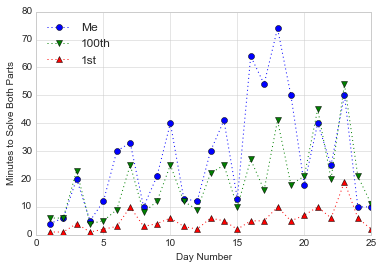

In [124]:
def plot_times(times):
    plt.style.use('seaborn-whitegrid')
    X = ints(1, len(times[0]) - 2)
    for (label, c, *Y) in times:
        plt.plot(X, Y, c+':', label=label)
    plt.xlabel('Day Number'); 
    plt.ylabel('Minutes to Solve Both Parts')
    plt.legend(loc='upper left')

plot_times([
 ('Me',   'o', 4, 6, 20, 5, 12, 30, 33, 10, 21, 40, 13, 12, 30, 41, 13, 64, 54, 74, 50, 18, 40, 25, 50, 10, 10),
 ('100th','v', 6, 6, 23, 4,  5,  9, 25,  8, 12, 25, 12,  9, 22, 25, 10, 27, 16, 41, 18, 21, 45, 20, 54, 21, 11),
 ('1st',  '^', 1, 1,  4, 1,  2,  3, 10,  3,  4,  6,  3,  2,  6,  5,  2,  5,  5, 10,  5,  7, 10,  6, 19,  6, 2)])